In [1]:
# # Download voting records
# base = 'https://www.govtrack.us/congress/votes/116-2020/'
# import urllib.request
# for x in range(1, 228):
#     x = str(x)
#     url = base + 'h' + x + '/export/csv'
#     file = x + '.csv'
#     urllib.request.urlretrieve(url, file)

In [2]:
# Extract bills
import pandas as pd
bills = []
for x in range(1, 228):
    file = 'data_house/' + str(x) + '.csv'
    bills_data = pd.read_csv(file)
    bill = bills_data.columns[0]
    bill = bill.split(' - ')[1]
    bills.append(bill)

In [3]:
# # Extract votes
# bill_nos = []
# names = []
# votes = []
# party = []
# for x in range(1, 228):
#     file = 'data_house/' + str(x) + '.csv'
#     votes_data = pd.read_csv(file, skiprows = 1)
#     length = len(votes_data)
#     for y in range (0, length):
#         bill_nos.append(x)
#         names.append(votes_data.iloc[y]['name'])
#         votes.append(votes_data.iloc[y]['vote'])
#         party.append(votes_data.iloc[y]['party'])

In [4]:
# # Get unique representatives
# unique_names = set(names)
# unique_names = list(unique_names)

In [5]:
# # Create data frame of all votes
# all_votes = pd.DataFrame({'BillNo': bill_nos, 'Name': names, 'Vote': votes, 'Party': party})

In [6]:
# # Create final data frame for analysis
# data = pd.DataFrame(columns = range(1, 228))
# data.insert(0, 'Representative', unique_names)
# data.index = unique_names
# data = data.drop('Representative', axis = 1)

In [7]:
# # Fill in final data frame
# for representative in unique_names:
#     for bill in range(1, 228):
#         rep_record = all_votes[all_votes['Name'] == representative]
#         if bill in list(rep_record['BillNo']):
#             rep_voteonbill = rep_record[rep_record['BillNo'] == bill]['Vote'].iloc[0]
#             data.loc[representative][bill] = rep_voteonbill
#         else:
#             data.loc[representative][bill] = None

In [8]:
# # Save to csv before naming columns (commas in bill names mess up .csv)
# data.to_csv('data_house\data.csv')

In [9]:
# Load csv to save time
import pandas as pd
data = pd.read_csv('data_house/data.csv', index_col = 0)

In [10]:
# Name columns
data.columns = bills

In [11]:
# Drop "Call of the House," 226 columns left
data = data.drop('Call of the House', axis = 1)

In [12]:
# Drop NAs, NAs are mostly non-50-states representatives + representatives who resigned
print(data.shape)
data = data.dropna(axis = 0)
print(data.shape)

(441, 226)
(425, 226)


In [13]:
# Quantify data
data = data.replace('Nay', 0)
data = data.replace('No', 0)
data = data.replace('Yea', 1)
data = data.replace('Aye', 1)
data = data.replace('Not Voting', 0.5)
data = data.replace('Present', 0.5)

In [14]:
# Only look at H.R. votes
filter_col = [col for col in data if col.startswith('H.R.')]
data = data[set(filter_col)]

Note: There are 2 duplicate columns because there were 2 votes on the same bill

In [15]:
# Extract and insert party
import re
party = []
for representative in data.index:
    res = re.findall(r'\[.*?\]', representative)
    res = res[0][1]
    party.append(res)
data.insert(0, 'Party', party)

In [16]:
# Principal component analysis
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(data.iloc[:,1:].T)
pca_data = pd.DataFrame(pca.components_)
pca_data = pca_data.T
pca_data.shape

(425, 32)

<AxesSubplot:xlabel='0', ylabel='1'>

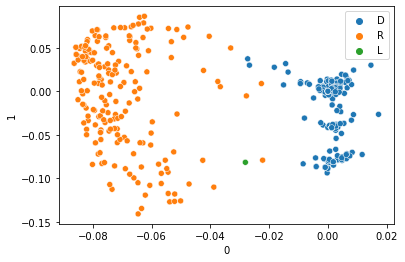

In [17]:
# Scatterplot of first two PCs with party as label
import seaborn as sns
sns.scatterplot(x = pca_data[0], y = pca_data[1], hue = data['Party'].values)

It looks like there are ~three distinct clusters of Democrats, what does this mean?

In [18]:
# Filter by Democrats
democrats = data[data['Party'] == 'D']

In [19]:
# Principal component analysis on Democrats
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.95)
pca.fit(democrats.iloc[:,1:].T)
pca_data = pd.DataFrame(pca.components_)
pca_data = pca_data.T
pca_data.shape

(230, 26)

<AxesSubplot:xlabel='0', ylabel='1'>

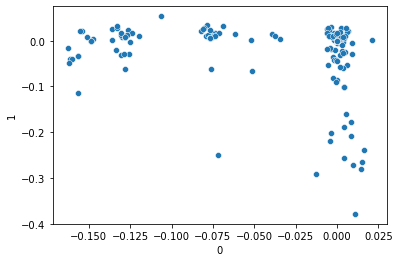

In [20]:
# Scatterplot of first two PCs
import seaborn as sns
sns.scatterplot(x = pca_data[0], y = pca_data[1])

In [21]:
# Insert PC1
democrats.insert(0, 'PC1', pca_data[0].values)

In [22]:
# PC1 seems to capture the most leftist representatives in the negative direction
democrats.sort_values('PC1').index[0:10]

Index(['Rep. Jesús García [D]', 'Rep. Ilhan Omar [D]',
       'Rep. Rashida Tlaib [D]', 'Rep. Alexandria Ocasio-Cortez [D]',
       'Rep. Ro Khanna [D]', 'Rep. Ayanna Pressley [D]',
       'Rep. Pramila Jayapal [D]', 'Rep. Lloyd Doggett [D]',
       'Rep. Jimmy Gomez [D]', 'Rep. Grace Meng [D]'],
      dtype='object')

In [23]:
# Insert PC2
democrats.insert(0, 'PC2', pca_data[1].values)

In [27]:
# PC2
democrats.sort_values('PC2').index[-10:]

Index(['Rep. Sheila Jackson Lee [D]', 'Rep. Bobby Rush [D]',
       'Rep. Tom O’Halleran [D]', 'Rep. Joaquin Castro [D]',
       'Rep. Kathleen Rice [D]', 'Rep. TJ Cox [D]', 'Rep. Peter DeFazio [D]',
       'Rep. Maxine Waters [D]', 'Rep. Raúl Grijalva [D]',
       'Rep. Tulsi Gabbard [D]'],
      dtype='object')

In [41]:
# Most negative correlations
democrats.corr()['PC2'].sort_values().index[0:5]

Index(['H.R. 6172: USA FREEDOM Reauthorization Act of 2020', 'PC1',
       'H.R. 5932: Ensuring Chinese Debt Transparency Act of 2020',
       'H.R. 4508: Malala Yousafzai Scholarship Act',
       'H.R. 5003: Fair Debt Collection Practices for Servicemembers Act'],
      dtype='object')

In [42]:
# Most positive correlations
democrats.corr()['PC2'].sort_values().index[-5:]

Index(['H.R. 7573: To direct the Joint Committee on the Library to replace the bust of Roger Brooke Taney in the Old Supreme Court Chamber of the United States Capitol with a bust of Thurgood Marshall to be obtained by the Joint Committee on the Library and to r',
       'H.R. 5664: LIFT Act', 'H.R. 7027: Child Care Is Essential Act',
       'H.R. 7120: George Floyd Justice in Policing Act of 2020',
       'H.R. 7010: Paycheck Protection Program Flexibility Act of 2020'],
      dtype='object')